In [214]:
import numpy as np
import matplotlib.pyplot as plt
import warnings

In [253]:
# Biological Parameters
w_inf = 6       # Maximum possible biomass in kg
a = 1.113       # Growth constant (scales growth)
b = 1.097       # Shape parameter
c_ONP = 1.43        # Growth rate constant
c_CCS = 1.43
initial_fish = 200000            # Initial number of fish in knot
initial_biomass = 0.2            # Initial weight of fish in kg
FCR_CCS = 1.27
FCR_ONP = 1.27

In [ ]:
# Simulation parameters
time_horizon = 3                 # in years
dt = 0.01                        # Time step
T = int(time_horizon / dt)       # Number of time steps
num_simulations = 10000            # Number of Monte Carlo paths
time = np.linspace(0, time_horizon, T)

In [217]:
# Economic Parameters
initial_price = 0.84 * 76.03
harvesting_cost_per_kg = 3       # Cost of harvest per kg in NOK
feed_cost_per_kg_year = 7        # Cost of feed per kg per year in NOK
lice_treatment_cost_global = 1000000    # Cost of lice treatment
r = 0.0352                       # Discount rate

In [218]:
# Host-Parasite Interaction Parameters
mu = 0.025                       # Intrinsic mortality of salmon (OpenKnot)
alpha = 0.1                      # Mortality from lice per salmon
mu_smoltification_inc = 0.2
mu_smoltification_inc_CCS = 0.2
weight_mort_inc = 0.001
weight_mort_inc_CCS = 0.001
lambda_growth_global = 7.0143           # Lice growth rate
lice_threshold_global = 0.5             # Lice per fish threshold for removal
beta1 = 0.0829                   # Beta distribution parameter for removal success
beta2 = 0.0281                   # Beta distribution parameter for removal success
reduced_growth_treatment = 0.01  # How lice treatments will impact growth rate

In [219]:
# von Bertalanffy growth function for biomass B(t)
def biomass(t, w_inf, a, b, c, lice_per_fish_value):
    if lice_per_fish_value > 0:
        return w_inf * (a - b * np.exp(-c * t)) ** 3 + initial_biomass
    else:
        return w_inf * (a - b * np.exp(-c * t)) ** 3 + initial_biomass

In [220]:
# Function to calculate dynamic mortality rate based on weight and lice count
def calculate_mortality_rate_dynamic(B_t, lice_per_fish_value, t, dt, mu_smoltification_inc, mu_smoltification_inc_CCS, weight_mort_inc, weight_mort_inc_CCS):
    if t * dt <= 3/12:  # First three months
        if lice_per_fish_value > 0:
            mortality_rate_dynamic = mu_smoltification_inc
        else:
            mortality_rate_dynamic = mu_smoltification_inc_CCS
    elif t * dt <= 1:
        if lice_per_fish_value > 0:
            mortality_rate_dynamic = mu + alpha * lice_per_fish_value
        else:
            mortality_rate_dynamic = mu
    else: 
        if lice_per_fish_value > 0:
            mortality_rate_dynamic = mu + (weight_mort_inc * B_t ** 2) + alpha * lice_per_fish_value
        else:
            mortality_rate_dynamic = mu + (weight_mort_inc_CCS * B_t ** 2)
    return mortality_rate_dynamic

In [221]:
# Function to simulate fish population with cumulative mortality and calculate average dead weight
def simulate_paths(num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, initial_lice_per_fish, FCR, mu_smoltification_inc, mu_smoltification_inc_CCS, weight_mort_inc, weight_mort_inc_CCS, c, lice_treatment_cost, lambda_growth, lice_threshold):
    # Initialize arrays to store simulation results
    all_values = np.zeros((num_simulations, T))
    harvesting_costs = np.zeros((num_simulations, T))
    feed_costs = np.zeros((num_simulations, T))
    treatment_costs = np.zeros((num_simulations, T))
    lice_per_fish = np.zeros((num_simulations, T))
    mortality_rate = np.zeros((num_simulations, T))
    total_mortality = np.zeros((num_simulations, T))
    average_dead_weight = np.zeros(num_simulations)  # To store average dead weight for each simulation
    B_t_array = np.zeros((num_simulations, T))  # Biomass at each time step
    D_t_array = np.zeros((num_simulations, T))  # Deaths at each time step

    for i in range(num_simulations):
        c_simulation = c
        N_t = initial_fish
        P_t = initial_lice_per_fish * N_t  # Initial lice population
        price = initial_price
        cumulative_feed_cost = 0
        cumulative_treatment_cost = 0
        cumulative_death = 0

        for t in range(T):
            lice_per_fish_value = P_t / N_t
            lice_per_fish[i, t] = lice_per_fish_value
            B_t = biomass(t * dt, w_inf, a, b, c_simulation, lice_per_fish_value)
            B_t_array[i, t] = B_t  # Store B_t

            # Calculate dynamic mortality rate
            mortality_rate_dynamic = calculate_mortality_rate_dynamic(B_t, lice_per_fish_value, t, dt, mu_smoltification_inc, mu_smoltification_inc_CCS, weight_mort_inc, weight_mort_inc_CCS)
            mortality_rate[i, t] = mortality_rate_dynamic

            feed_cost_t = B_t * N_t * feed_cost_per_kg_year * dt * FCR

            # Update number of fish based on cumulative mortality
            D_t = N_t * mortality_rate_dynamic * dt
            D_t_array[i, t] = D_t  # Store D_t
            cumulative_death += D_t
            N_t -= D_t
            N_t = max(N_t, 0)  # Ensure N_t doesn't go below zero

            # Update lice population
            if N_t > 0:
                P_t += (lambda_growth * (N_t / initial_fish) - (mu + alpha * lice_per_fish_value)) * P_t * dt
            else:
                P_t = 0  # No fish left, so lice population is zero

            # Lice removal if the threshold is exceeded
            if lice_per_fish_value >= lice_threshold and N_t > 0:
                removal_success = 0.1 + 0.8 * np.random.beta(beta1, beta2)
                P_t *= (1 - removal_success)
                # Small mortality from treatment
                mortality_from_treatment = N_t * (1 - np.random.uniform(0.995, 1.0))
                N_t -= mortality_from_treatment
                N_t = max(N_t, 0)
                cumulative_treatment_cost += lice_treatment_cost
                c_simulation *= (1 - reduced_growth_treatment)
                # Add treatment deaths to D_t_array
                D_t_array[i, t] += mortality_from_treatment
                # Update cumulative_death with treatment deaths
                cumulative_death += mortality_from_treatment

            # Calculate feed cost and cumulative feed cost
            cumulative_feed_cost += feed_cost_t
            feed_costs[i, t] = cumulative_feed_cost

            # Calculate cumulative treatment cost
            treatment_costs[i, t] = cumulative_treatment_cost
            total_mortality[i, t] = cumulative_death

            # Value at time t (Biomass * Number of Fish * Spot Price) minus costs
            all_values[i, t] = B_t * N_t * price - feed_costs[i, t] - treatment_costs[i, t]
            harvesting_costs[i, t] = B_t * N_t * harvesting_cost_per_kg

        # Calculate average dead weight for this simulation
        total_D_t = np.sum(D_t_array)
        if total_D_t > 0:
            average_dead_weight[i] = np.sum(D_t_array * B_t_array) / total_D_t
        else:
            average_dead_weight[i] = 0  # No deaths occurred

    return (all_values, harvesting_costs, feed_costs, lice_per_fish, treatment_costs,
            mortality_rate, total_mortality, B_t_array, D_t_array)

In [222]:
def continuation_value(value_salmon, discounted_payoff, degree=3):
    warnings.simplefilter('ignore', np.RankWarning)
    """
    Calculates the continuation value using polynomial regression.
    
    Parameters:
    - value_salmon: Current value of salmon for in-the-money paths.
    - discounted_payoff: Discounted payoff for in-the-money paths.
    - degree: Degree of the polynomial for the regression.
    
    Returns:
    - Continuation values.
    """
    # Fit a polynomial regression model
    coeffs = np.polyfit(value_salmon, discounted_payoff, deg=degree)
    return np.polyval(coeffs, value_salmon)

def lsmc(paths, K, r, T, n_steps, B_t, D_t, poly_degree=3):
    """
    Implements the Longstaff-Schwartz Least Squares Monte Carlo (LSM) algorithm to price American options.

    Parameters:
        paths (ndarray): Simulated asset price paths (number of paths, number of time steps).
        K (float): Cost of Harvest C(H)
        r (float): Risk-free interest rate (annual).
        T (float): Maximum growth time (time to maturity)
        n_steps (int): Number of discrete time steps.
        poly_degree (int): Degree of polynomial used in regression for continuation values.

    Returns:
        tuple: Estimated value of knot, an array of optimal exercise times, average dead weight of fish and total mortality rate at harvest.
    """
    dt = T / n_steps
    discount = np.exp(-r * dt)
    
    immediate_exercise_value = np.maximum(paths - K, 0)
    discounted_cash_flow = immediate_exercise_value[:, -1]
    exercise_times = np.full(paths.shape[0], n_steps)
    average_dead_weight = np.zeros(paths.shape[0])  # Fixed-size array for average dead weights
    total_mortality = np.zeros(paths.shape[0])  # Fixed-size array for total mortality


    for t in range(n_steps - 1, 0, -1):
        in_the_money = (paths[:, t] > K[:, t])
        paths_itm = np.where(in_the_money)[0]
        discounted_cash_flow *= discount

        if len(paths_itm) > 0:
            X = paths[paths_itm, t]
            Y = discounted_cash_flow[paths_itm]

            continuation_vals = continuation_value(X, Y, degree=poly_degree)
            exercise = immediate_exercise_value[in_the_money, t] > continuation_vals
            discounted_cash_flow[in_the_money] = np.where(exercise, immediate_exercise_value[in_the_money, t], Y)
            exercise_times[in_the_money] = np.where(exercise, t, exercise_times[in_the_money])
    for i in range(num_simulations):
        total_D_t = np.sum(D_t[i][:exercise_times[i] + 1])
        average_dead_weight[i] = np.sum(D_t[i][:exercise_times[i] + 1] * B_t[i][:exercise_times[i] + 1]) / total_D_t
        total_mortality[i] = total_D_t / initial_fish

    knot_value = np.mean(discounted_cash_flow) * discount
    return knot_value, exercise_times, average_dead_weight, np.mean(total_mortality)

In [223]:
# Run Monte Carlo simulation without initial lice infestation
results_no_lice = simulate_paths(num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0, FCR_CCS, mu_smoltification_inc, mu_smoltification_inc_CCS, weight_mort_inc, weight_mort_inc_CCS, c_CCS, lice_treatment_cost_global, lambda_growth_global, lice_threshold_global)
(simulated_values_no_lice, harvesting_costs_no_lice, feed_costs_no_lice, lice_per_fish_no_lice,
 treatment_costs_no_lice, mortality_rate_no_lice, cumulative_death_no_lice, B_t_no_Lice, D_t_no_Lice) = results_no_lice

# Run Monte Carlo simulation with initial lice infestation
results_lice = simulate_paths(num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0.001, FCR_ONP, mu_smoltification_inc, mu_smoltification_inc_CCS, weight_mort_inc, weight_mort_inc_CCS, c_ONP, lice_treatment_cost_global, lambda_growth_global, lice_threshold_global)
(simulated_values, harvesting_costs, feed_costs, lice_per_fish, treatment_costs,
 mortality_rate, cumulative_death, B_t, D_t) = results_lice

In [224]:
knot_value, exercise_times, average_dead_weight, average_mortality_rate = lsmc(simulated_values, harvesting_costs, r, time_horizon, T, B_t, D_t)
knot_value_no_lice, exercise_times_no_lice, average_dead_weight_no_lice, average_mortality_rate_no_lice = lsmc(simulated_values_no_lice, harvesting_costs, r, time_horizon, T, B_t_no_Lice, D_t_no_Lice)
    
print('One round of salmon farming with lice infestations is worth:', round(knot_value, 2), 'NOK')
print('One round of salmon farming without lice infestations is worth:', round(knot_value_no_lice, 2), 'NOK')
print('Difference: ', knot_value_no_lice - knot_value)
print('Difference (%):', round((knot_value_no_lice / knot_value) - 1, 2) * 100, '%')

#Important to remember that this is only the revenue gain, not the gains in profits from no lice_removal costs
# results = np.zeros(M)

mean_average_dead_weight = np.mean(average_dead_weight)
mean_average_dead_weight_no_lice = np.mean(average_dead_weight_no_lice)

print('Average mortality rate at harvest: ', round(average_mortality_rate * 100, 2), '%')
print('Average mortality rate at harvest with no lice: ', round(average_mortality_rate_no_lice * 100, 2), '%')

print(f"Average weight at death with lice: {mean_average_dead_weight:.2f} kg")
print(f"Average weight at death without lice: {mean_average_dead_weight_no_lice:.2f} kg")

One round of salmon farming with lice infestations is worth: 52991213.32 NOK
One round of salmon farming without lice infestations is worth: 60302736.81 NOK
Difference:  7311523.492025159
Difference (%): 14.000000000000002 %
Average mortality rate at harvest:  13.17 %
Average mortality rate at harvest with no lice:  12.1 %
Average weight at death with lice: 2.78 kg
Average weight at death without lice: 2.99 kg


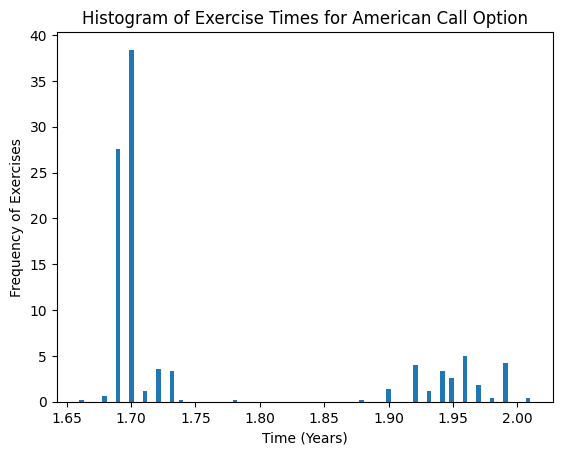

In [ ]:
M = 5
# Initialize counters
all_exercise_times_ONP = np.array([])


# Perform M Monte Carlo simulations
for m in range(M):
    # Simulate paths
    paths, harvesting_costs, feed_costs, lice_per_fish, treatment_cost_lice, mortality_lice, _, B_t, D_t = simulate_paths(
        num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0.001, FCR_ONP, mu_smoltification_inc, mu_smoltification_inc_CCS, weight_mort_inc, weight_mort_inc_CCS, c_ONP, lice_treatment_cost_global, lambda_growth_global, lice_threshold_global
    )
    # Analyze the paths using the LSM method to get exercise times
    _, exercise_times, average_dead_weight, _ = lsmc(paths, harvesting_costs, r, time_horizon, T, B_t, D_t)

    # Count instances of exercise times (using raw exercise_times)

    # Collect all exercise times for plotting
    all_exercise_times_ONP = np.concatenate((all_exercise_times_ONP, exercise_times))

# Convert exercise times to years and round to two decimal places
all_exercise_times_in_years_ONP = np.round(all_exercise_times_ONP / 100, 2)

# Plot the histogram with updated exercise times
plt.hist(all_exercise_times_in_years_ONP, bins=T//3, weights=np.ones_like(all_exercise_times_in_years_ONP)/M)
plt.title('Histogram of Harvesting Times for ONP')
plt.xlabel('Time (Years)')
plt.ylabel('Frequency of Harvest')
plt.show()

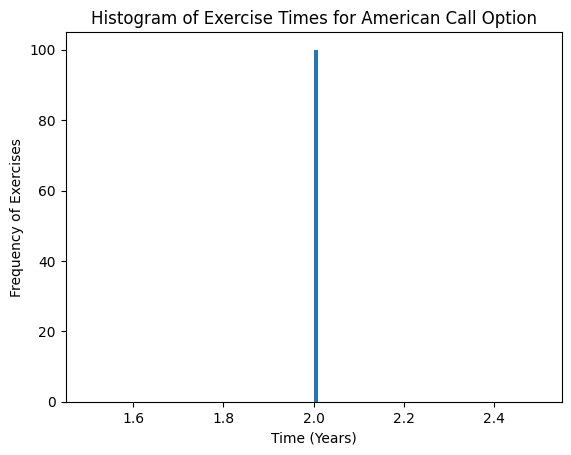

In [ ]:
M = 1
# Initialize counters
all_exercise_times_CCS = np.array([])


# Perform M Monte Carlo simulations
for m in range(M):
    # Simulate paths
    paths, harvesting_costs, feed_costs, lice_per_fish, treatment_cost_lice, mortality_lice, _, B_t, D_t = simulate_paths(
        num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0, FCR_CCS, mu_smoltification_inc, mu_smoltification_inc_CCS, weight_mort_inc, weight_mort_inc_CCS, c_CCS, lice_treatment_cost_global, lambda_growth_global, lice_threshold_global
    )
    # Analyze the paths using the LSM method to get exercise times
    _, exercise_times, average_dead_weight, _ = lsmc(paths, harvesting_costs, r, time_horizon, T, B_t, D_t)

    # Count instances of exercise times (using raw exercise_times)

    # Collect all exercise times for plotting
    all_exercise_times_CCS = np.concatenate((all_exercise_times_CCS, exercise_times))

# Convert exercise times to years and round to two decimal places
all_exercise_times_in_years_CCS = np.round(all_exercise_times_CCS / 100, 2)

# Plot the histogram with updated exercise times
plt.hist(all_exercise_times_in_years_CCS, bins=T//3, weights=np.ones_like(all_exercise_times_in_years_CCS)/M)
plt.title('Histogram of Harvesting Times for CCS')
plt.xlabel('Time (Years)')
plt.ylabel('Frequency of Harvest')
plt.show()

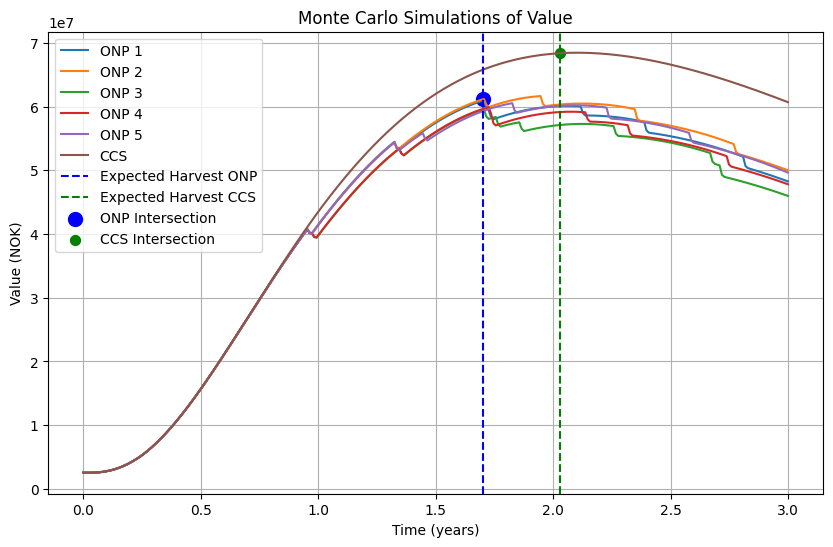

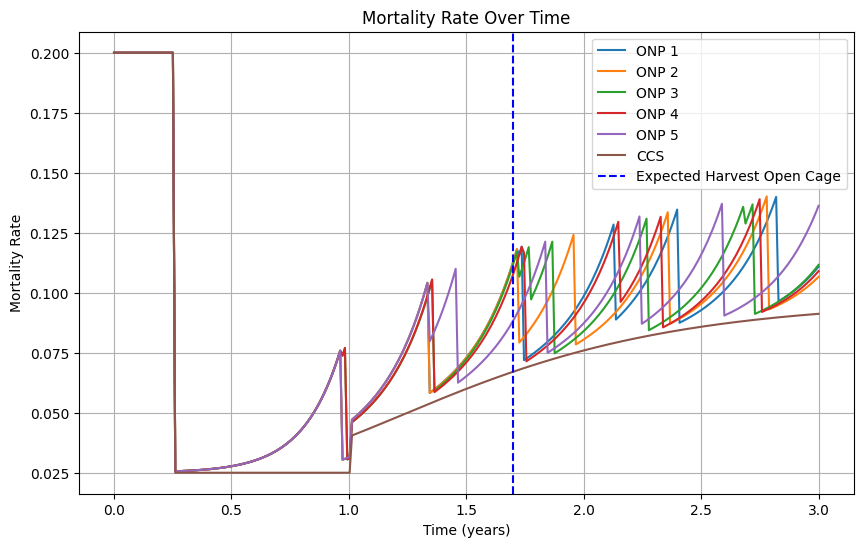

In [245]:
# Defining harvest line information
harvest_lines = [
    (1.7, "Expected Harvest ONP", 'blue'), 
    (2.03, "Expected Harvest CCS", 'green')
]

# Updated plotting with consistent lines for all provided plots

# Plotting simulated values (Value)
plt.figure(figsize=(10, 6))
for i in range(5):  # Plot 5 random paths with lice infestations
    plt.plot(time, simulated_values[i, :], label=f"ONP {i+1}")
for i in range(1):  # Plot 1 random path without lice
    plt.plot(time, simulated_values_no_lice[i, :], label="CCS")
for line, label, color in harvest_lines:
    plt.axvline(x=line, color=color, linestyle='--', label=label)
# Find and plot the first intersection for the Open Cage (ONP) line
onp_time = harvest_lines[0][0]  # Time for Open Cage harvest
onp_index = np.argmin(np.abs(time - onp_time))  # Closest index to the harvest time
onp_value = simulated_values[:, onp_index]  # Values at the intersection time
first_onp_intersection = np.max(onp_value)  # Choose the highest value for clarity
plt.scatter(onp_time, first_onp_intersection, color='blue', marker='o', s=100, label="ONP Intersection")

# Find and plot the last intersection for the CCS line
ccs_time = harvest_lines[1][0]  # Time for CCS harvest
ccs_index = np.argmin(np.abs(time - ccs_time))  # Closest index to the harvest time
ccs_value = simulated_values_no_lice[0, ccs_index]  # Value at the intersection time
plt.scatter(ccs_time, ccs_value, color='green', marker='o', s=50, label="CCS Intersection")

plt.title("Monte Carlo Simulations of Value")
plt.xlabel("Time (years)")
plt.ylabel("Value (NOK)")
plt.grid(True)
plt.legend()
plt.show()

harvest_lines = [
    (1.7, "Expected Harvest Open Cage", 'blue'), 
]

# Plotting mortality rate dynamics
plt.figure(figsize=(10, 6))
for i in range(5):  # Plot 5 random paths with lice
    plt.plot(time, mortality_rate[i, :], label=f"ONP {i+1}")
for i in range(1):  # Plot 1 random path without lice
    plt.plot(time, mortality_rate_no_lice[i, :], label="CCS")
for line, label, color in harvest_lines:
    plt.axvline(x=line, color=color, linestyle='--', label=label)
plt.title("Mortality Rate Over Time")
plt.xlabel("Time (years)")
plt.ylabel("Mortality Rate")
plt.grid(True)
plt.legend()
plt.show()

In [228]:
# Define parameter ranges for scenario analysis
FCR_CCS_values = np.linspace(1.0, 1.25, num=10)
mu_smoltification_inc_CCS_values = np.linspace(0.2, 0.3, num=10)
weight_mort_inc_CCS_values = np.linspace(0.0006, 0.001, num=10)
c_CCS_values = np.linspace(1.43, 1.53, num=10)  # Growth rate constant for CCS
lambda_growth_values = np.linspace(5.0, 10.0, num=30)

Testing lambda_growth = 5.00
lambda_growth: 5.00, Value Difference: 3705550.71
Testing lambda_growth = 5.17
lambda_growth: 5.17, Value Difference: 4017331.12
Testing lambda_growth = 5.34
lambda_growth: 5.34, Value Difference: 4636318.47
Testing lambda_growth = 5.52
lambda_growth: 5.52, Value Difference: 5247675.04
Testing lambda_growth = 5.69
lambda_growth: 5.69, Value Difference: 5629669.93
Testing lambda_growth = 5.86
lambda_growth: 5.86, Value Difference: 5787423.67
Testing lambda_growth = 6.03
lambda_growth: 6.03, Value Difference: 5578764.40
Testing lambda_growth = 6.21
lambda_growth: 6.21, Value Difference: 5962870.51
Testing lambda_growth = 6.38
lambda_growth: 6.38, Value Difference: 6083977.59
Testing lambda_growth = 6.55
lambda_growth: 6.55, Value Difference: 6598762.57
Testing lambda_growth = 6.72
lambda_growth: 6.72, Value Difference: 6310878.58
Testing lambda_growth = 6.90
lambda_growth: 6.90, Value Difference: 6742506.91
Testing lambda_growth = 7.07
lambda_growth: 7.07, Va

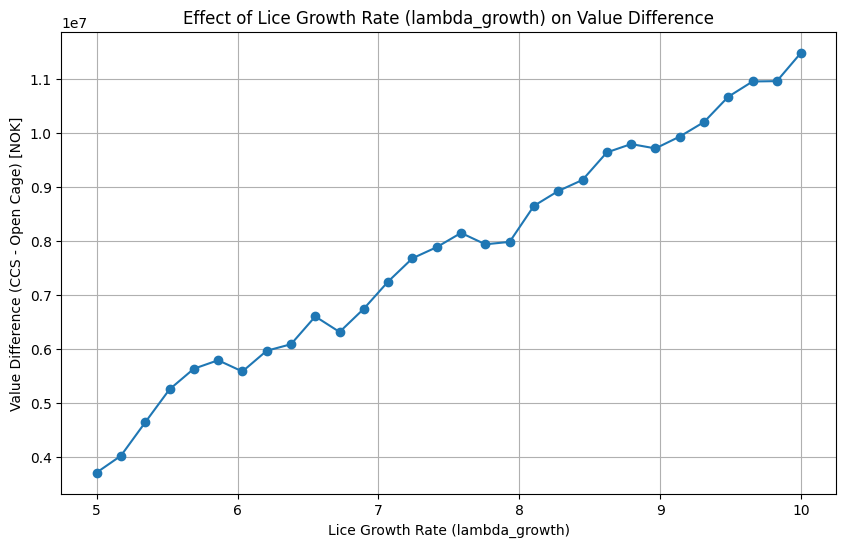

In [229]:
value_differences = np.zeros(len(lambda_growth_values))

for idx, lambda_growth_current in enumerate(lambda_growth_values):
    print(f"Testing lambda_growth = {lambda_growth_current:.2f}")

    # Simulate open cage (with lice)
    results_open = simulate_paths(
        num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year,
        0.001, FCR_ONP, mu_smoltification_inc, mu_smoltification_inc_CCS, weight_mort_inc, weight_mort_inc_CCS, c_ONP, lice_treatment_cost_global, lambda_growth_current, lice_threshold_global
    )
    (simulated_values_open, harvesting_costs_open, feed_costs_open, lice_per_fish_open, treatment_costs_open,
     mortality_rate_open, cumulative_death_open, B_t_open, D_t_open) = results_open

    knot_value_open, exercise_times_open, average_dead_weight_open, avg_mortality_rate_open = lsmc(
        simulated_values_open, harvesting_costs_open, r, time_horizon, T, B_t_open, D_t_open
    )

    # Simulate CCS (without lice, lambda_growth doesn't affect CCS since initial_lice_per_fish = 0)
    # However, for consistency, we'll pass lambda_growth_current
    results_CCS = simulate_paths(
        num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year,
        0, FCR_CCS, mu_smoltification_inc, mu_smoltification_inc_CCS, weight_mort_inc, weight_mort_inc_CCS, c_CCS, lice_treatment_cost_global, lambda_growth_current, lice_threshold_global
    )
    (simulated_values_CCS, harvesting_costs_CCS, feed_costs_CCS, lice_per_fish_CCS,
     treatment_costs_CCS, mortality_rate_CCS, cumulative_death_CCS, B_t_CCS, D_t_CCS) = results_CCS

    knot_value_CCS, exercise_times_CCS, average_dead_weight_CCS, avg_mortality_rate_CCS = lsmc(
        simulated_values_CCS, harvesting_costs_CCS, r, time_horizon, T, B_t_CCS, D_t_CCS
    )

    # Calculate value difference
    value_diff = knot_value_CCS - knot_value_open
    value_differences[idx] = value_diff

    print(f"lambda_growth: {lambda_growth_current:.2f}, Value Difference: {value_diff:.2f}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(lambda_growth_values, value_differences, marker='o')
plt.title('Effect of Lice Growth Rate (lambda_growth) on Value Difference')
plt.xlabel('Lice Growth Rate (lambda_growth)')
plt.ylabel('Value Difference (CCS - Open Cage) [NOK]')
plt.grid(True)
plt.show()

1.8552000000000004 5.0
1.8257999999999996 5.1020408163265305
1.7825 5.204081632653061
1.7705000000000002 5.3061224489795915
1.7192 5.408163265306122
1.7107 5.510204081632653
1.7546000000000002 5.612244897959184
1.9364999999999992 5.714285714285714
1.9559 5.816326530612245
1.9362000000000001 5.918367346938775
1.9327999999999994 6.020408163265306
1.9195999999999998 6.122448979591837
1.8785999999999998 6.224489795918368
1.8452000000000002 6.326530612244898
1.8495000000000001 6.428571428571429
1.8237999999999999 6.530612244897959
1.8051000000000004 6.63265306122449
1.7795 6.73469387755102
1.7496999999999998 6.836734693877551
1.7257999999999998 6.938775510204081
1.6945999999999999 7.040816326530612
1.7486999999999995 7.142857142857142
1.8573 7.244897959183674
1.9201 7.346938775510204
1.9219999999999993 7.448979591836735
1.8874000000000002 7.551020408163265
1.8985000000000003 7.653061224489796
1.8667000000000005 7.755102040816327
1.8617000000000004 7.857142857142858
1.8297000000000003 7.9591

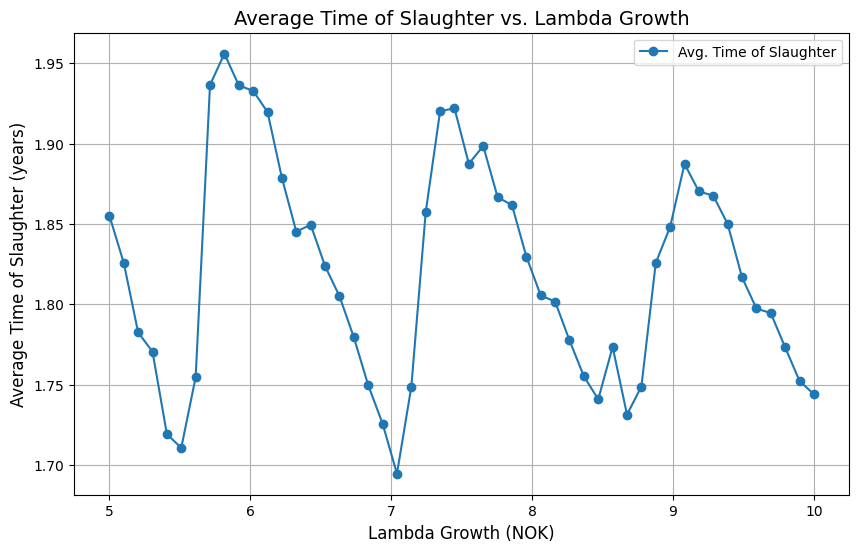

In [230]:
import numpy as np
import matplotlib.pyplot as plt

adjustment_lambda_growths = np.linspace(5, 10, 50)

# Placeholder for average time of slaughter values
# Replace these with actual simulation results
average_times_of_slaughter = []
for lambda_growth in adjustment_lambda_growths:
    # Adjust variables for the simulation
    adjustment_lambda_growth = lambda_growth
    # Simulate with adjusted treatment cost (assuming your function and variables are defined)
    paths, harvesting_costs, feed_costs, lice_per_fish, treatment_cost_lice, mortality_lice, _, B_t, D_t = simulate_paths(
        num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0.001, FCR_ONP, mu_smoltification_inc, mu_smoltification_inc_CCS, weight_mort_inc, weight_mort_inc_CCS, c_CCS, lice_treatment_cost_global, lambda_growth, lice_threshold_global
    )
    # Analyze the paths using the LSM method
    value, exercise_times, average_dead_weight, _ = lsmc(paths, harvesting_costs, r, time_horizon, T, B_t, D_t)

    # Calculate the average time of slaughter
    time_of_slaughter = np.mean(exercise_times * dt)
    average_times_of_slaughter.append(time_of_slaughter)
    print(time_of_slaughter, lambda_growth)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(adjustment_lambda_growths[::-1], average_times_of_slaughter[::-1], marker='o', linestyle='-', label='Avg. Time of Slaughter')
plt.xlabel('Lambda Growth (NOK)', fontsize=12)
plt.ylabel('Average Time of Slaughter (years)', fontsize=12)
plt.title('Average Time of Slaughter vs. Lambda Growth', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

1.450395 4200000.0
1.4568800000000002 4130508.474576271
1.455625 4061016.9491525423
1.45161 3991525.4237288134
1.458525 3922033.8983050846
1.4569349999999996 3852542.3728813557
1.45869 3783050.847457627
1.4571550000000002 3713559.3220338984
1.4617399999999998 3644067.7966101696
1.46038 3574576.2711864407
1.46088 3505084.745762712
1.4562299999999997 3435593.220338983
1.456895 3366101.694915254
1.46287 3296610.1694915253
1.458 3227118.6440677964
1.459365 3157627.118644068
1.461095 3088135.593220339
1.459505 3018644.0677966103
1.463315 2949152.5423728814
1.4622399999999998 2879661.0169491526
1.45544 2810169.4915254237
1.4620349999999998 2740677.966101695
1.461555 2671186.440677966
1.5497150000000002 2601694.915254237
1.5365100000000003 2532203.3898305083
1.64711 2462711.8644067794
1.6196200000000003 2393220.3389830505
1.64436 2323728.8135593217
1.6546800000000002 2254237.288135593
1.721405 2184745.762711864
1.7015850000000001 2115254.2372881356
1.7301900000000001 2045762.7118644067
1.7350

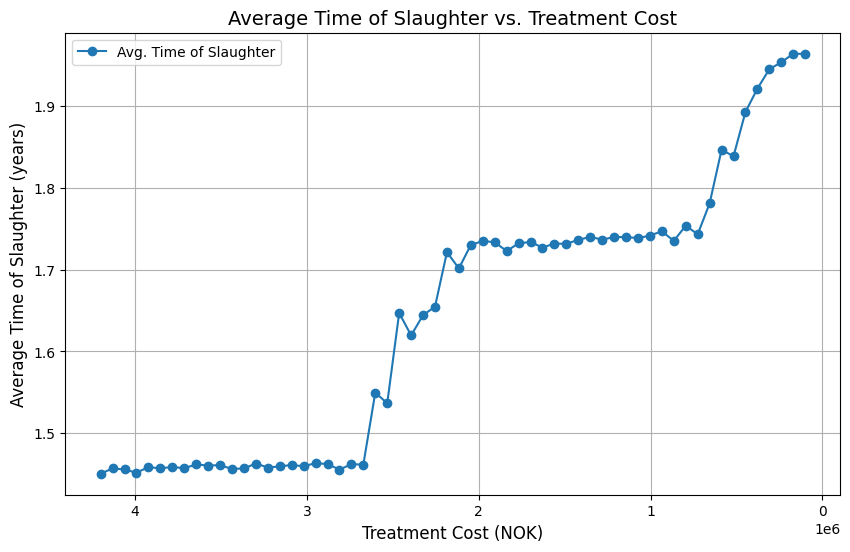

In [248]:
import numpy as np
import matplotlib.pyplot as plt

# Define the treatment costs (20 values between 4.2 million and 100,000)
treatment_costs = np.linspace(4200000, 100000, 60)

num_simulations = 2000

# Placeholder for average time of slaughter values
# Replace these with actual simulation results
average_times_of_slaughter = []
for cost in treatment_costs:
    # Adjust variables for the simulation
    adjusted_lice_treatment_cost = cost
    # Simulate with adjusted treatment cost (assuming your function and variables are defined)
    paths, harvesting_costs, feed_costs, lice_per_fish, treatment_cost_lice, mortality_lice, _, B_t, D_t = simulate_paths(
        num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0.001, FCR_ONP, mu_smoltification_inc, mu_smoltification_inc_CCS, weight_mort_inc, weight_mort_inc_CCS, c_CCS, cost, lambda_growth, lice_threshold_global
    )
    # Analyze the paths using the LSM method
    value, exercise_times, average_dead_weight, _ = lsmc(paths, harvesting_costs, r, time_horizon, T, B_t, D_t)

    # Calculate the average time of slaughter
    time_of_slaughter = np.mean(exercise_times * dt)
    average_times_of_slaughter.append(time_of_slaughter)
    print(time_of_slaughter, cost)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(treatment_costs, average_times_of_slaughter, marker='o', linestyle='-', label='Avg. Time of Slaughter')
plt.xlabel('Treatment Cost (NOK)', fontsize=12)
plt.ylabel('Average Time of Slaughter (years)', fontsize=12)
plt.title('Average Time of Slaughter vs. Treatment Cost', fontsize=14)
plt.grid(True)
plt.gca().invert_xaxis()  # Invert x-axis to show higher treatment cost on the left
plt.legend()
plt.show()

num_simulations = 100


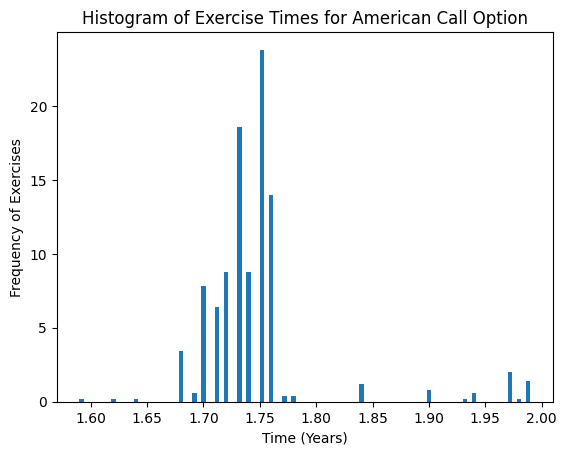

In [232]:
M = 5
# Initialize counters
all_exercise_times_ONP = np.array([])
lice_treatment_cost = 1300000


# Perform M Monte Carlo simulations
for m in range(M):
    # Simulate paths
    paths, harvesting_costs, feed_costs, lice_per_fish, treatment_cost_lice, mortality_lice, _, B_t, D_t = simulate_paths(
        num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0.001, FCR_ONP, mu_smoltification_inc, mu_smoltification_inc_CCS, weight_mort_inc, weight_mort_inc_CCS, c_CCS, lice_treatment_cost_global, lambda_growth, lice_threshold_global
    )
    # Analyze the paths using the LSM method to get exercise times
    _, exercise_times, average_dead_weight, _ = lsmc(paths, harvesting_costs, r, time_horizon, T, B_t, D_t)

    # Count instances of exercise times (using raw exercise_times)

    # Collect all exercise times for plotting
    all_exercise_times_ONP = np.concatenate((all_exercise_times_ONP, exercise_times))

# Convert exercise times to years and round to two decimal places
all_exercise_times_in_years_ONP = np.round(all_exercise_times_ONP / 100, 2)

# Plot the histogram with updated exercise times
plt.hist(all_exercise_times_in_years_ONP, bins=T//3, weights=np.ones_like(all_exercise_times_in_years_ONP)/M)
plt.title('Histogram of Exercise Times for American Call Option')
plt.xlabel('Time (Years)')
plt.ylabel('Frequency of Exercises')
plt.show()

In [233]:
import pandas as pd
import numpy as np

# Example lice thresholds to test
lice_thresholds = [0.1, 0.2, 0.3, 0.4]

num_simulations = 100
runs_per_threshold = 3
results = []

# Run the regular (mandated) scenario multiple times and average
regular_values = []
regular_times = []
regular_weights = []
regular_dead_weights = []

for _ in range(runs_per_threshold):
    (paths_reg,
     harvesting_costs_reg,
     feed_costs_reg,
     lice_per_fish_reg,
     treatment_cost_lice_reg,
     mortality_lice_reg,
     _,
     B_t_reg,
     D_t_reg) = simulate_paths(
        num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0.001, FCR_ONP, mu_smoltification_inc, mu_smoltification_inc_CCS, weight_mort_inc, weight_mort_inc_CCS, c_CCS, lice_treatment_cost_global, lambda_growth, 0.5
    )

    value_reg, exercise_times_reg, avg_dead_weight_reg, _ = lsmc(
        paths_reg, harvesting_costs_reg, r, time_horizon, T, B_t_reg, D_t_reg
    
    )
    print(value_reg)
    regular_values.append(value_reg)
    reg_avg_dead_weight_run = np.mean(avg_dead_weight_reg)
    reg_time_of_slaughter_run = np.mean(exercise_times_reg * dt)
    reg_slaughter_timestep_run = int(np.mean(exercise_times_reg))
    reg_fish_weight_at_slaughter_run = np.mean(B_t_reg[:, reg_slaughter_timestep_run])

    regular_times.append(reg_time_of_slaughter_run)
    regular_weights.append(reg_fish_weight_at_slaughter_run)
    regular_dead_weights.append(reg_avg_dead_weight_run)

# Average results for the regular scenario
value_regular = np.mean(regular_values)
time_of_slaughter_regular = np.mean(regular_times)
weight_at_slaughter_regular = np.mean(regular_weights)
dead_weight_regular = np.mean(regular_dead_weights)

# Now run each alternative threshold scenario multiple times
for threshold in lice_thresholds:
    threshold_values = []
    threshold_times = []
    threshold_weights = []
    threshold_dead_weights = []

    for i in range(runs_per_threshold):
        paths, harvesting_costs, feed_costs, lice_per_fish, treatment_cost_lice, mortality_lice, _, B_t, D_t = simulate_paths(
            num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0.001, FCR_ONP, mu_smoltification_inc, mu_smoltification_inc_CCS, weight_mort_inc, weight_mort_inc_CCS, c_CCS, lice_treatment_cost_global, lambda_growth, threshold
        )

        value, exercise_times, average_dead_weight, _ = lsmc(
            paths, harvesting_costs, r, time_horizon, T, B_t, D_t
        )
        print (value, threshold, i)

        avg_dead_weight_run = np.mean(average_dead_weight)
        time_of_slaughter_run = np.mean(exercise_times * dt)
        slaughter_timestep_run = int(np.mean(exercise_times))
        fish_weight_at_slaughter_run = np.mean(B_t[:, slaughter_timestep_run])

        threshold_values.append(value)
        threshold_times.append(time_of_slaughter_run)
        threshold_weights.append(fish_weight_at_slaughter_run)
        threshold_dead_weights.append(avg_dead_weight_run)

    # Average results for this threshold
    mean_value = np.mean(threshold_values)
    mean_time_of_slaughter = np.mean(threshold_times)
    mean_weight_at_slaughter = np.mean(threshold_weights)
    mean_dead_weight = np.mean(threshold_dead_weights)

    # Calculate difference in value relative to the regular scenario
    value_diff_kNOK = (mean_value - value_regular) / 1000

    results.append({
        "Lice Threshold": threshold,
        "Time of Slaughter (years)": round(mean_time_of_slaughter, 2),
        "Value Diff vs Regular (kNOK)": round(value_diff_kNOK, 2)
    })

# Convert results to a DataFrame and display
results_df = pd.DataFrame(results)
results_df

49072371.33021529
48961018.73405351
48881760.02424849
49025101.8419652 0.1 0
49020018.78518198 0.1 1
48963862.06036458 0.1 2
48924214.39520625 0.2 0
49050742.9050639 0.2 1
48975377.360130034 0.2 2
49011138.842997335 0.3 0
48896841.95748712 0.3 1
49339800.30646654 0.3 2
49154362.95167971 0.4 0
48741252.16488017 0.4 1
48897828.73218078 0.4 2


,Lice Threshold,Time of Slaughter (years),Value Diff vs Regular (kNOK)
0,0.1,1.82,31.28
1,0.2,1.87,11.73
2,0.3,1.83,110.88
3,0.4,1.77,-40.57


In [254]:
def run_scenarios():
    # Adjustments for the three parameters
    fcr_adjustments = [1, 0.95, 0.90, 0.85, 0.80]
    mort_adjustments = [1, 0.8, 0.6, 0.4, 0.2]
    growth_adjustments = [1, 0.95, 0.90, 0.85, 0.80]

    # Original baseline parameters
    baseline_fcr = FCR_CCS
    baseline_mort = weight_mort_inc_CCS
    baseline_growth = c_CCS

    # Storage for results
    fcr_results = []
    mort_results = []
    growth_results = []

    # 1) Varying FCR only
    for adj in fcr_adjustments:
        adjusted_fcr = baseline_fcr * adj
        adjusted_mort = baseline_mort        # unchanged
        adjusted_growth = baseline_growth    # unchanged

        paths, harvesting_costs_, feed_costs_, lice_pf_, treatment_c_, mort_, _, B_t_, D_t_ = simulate_paths(
            num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0, adjusted_fcr, mu_smoltification_inc, mu_smoltification_inc_CCS, weight_mort_inc, adjusted_mort, adjusted_growth, lice_treatment_cost_global, lambda_growth_global, lice_threshold_global
        )

        value, exercise_times_, avg_dead_wt_, _ = lsmc(paths, harvesting_costs_, r, time_horizon, T, B_t_, D_t_)
        avg_dead_weight_mean = np.mean(avg_dead_wt_)
        time_of_slaughter = np.mean(exercise_times_ * dt)
        slaughter_timestep = int(np.mean(exercise_times_))
        fish_weight_at_slaughter = np.mean(B_t_[:, slaughter_timestep])
        value_at_slaughter = value / 1_000_000

        fcr_results.append({
            "FCR Adjustment (%)": f"{round((1 - adj)*100)}%",
            "FCR": round(adjusted_fcr, 4),
            "Weight Mortality Increment": round(adjusted_mort, 6),
            "Growth Rate (c)": round(adjusted_growth, 4),
            "Average Dead Weight (kg)": round(avg_dead_weight_mean, 2),
            "Fish Weight at Slaughter (kg)": round(fish_weight_at_slaughter, 2),
            "Time of Slaughter (years)": round(time_of_slaughter, 2),
            "Value at Slaughter (MNOK)": round(value_at_slaughter - knot_value / 1_000_000, 3)
        })

    # 2) Varying Mortality Increment only
    for adj in mort_adjustments:
        adjusted_fcr = baseline_fcr
        adjusted_mort = baseline_mort * adj
        adjusted_growth = baseline_growth

        paths, harvesting_costs_, feed_costs_, lice_pf_, treatment_c_, mort_, _, B_t_, D_t_ = simulate_paths(
            num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0, adjusted_fcr, mu_smoltification_inc, mu_smoltification_inc_CCS, weight_mort_inc, adjusted_mort, adjusted_growth, lice_treatment_cost_global, lambda_growth_global, lice_threshold_global
        )

        value, exercise_times_, avg_dead_wt_, total_mortality = lsmc(paths, harvesting_costs_, r, time_horizon, T, B_t_, D_t_)
        avg_dead_weight_mean = np.mean(avg_dead_wt_)
        time_of_slaughter = np.mean(exercise_times_ * dt)
        slaughter_timestep = int(np.mean(exercise_times_))
        fish_weight_at_slaughter = np.mean(B_t_[:, slaughter_timestep])
        value_at_slaughter = value / 1_000_000

        mort_results.append({
            "Mortality Increment Adjustment (%)": f"{round((1 - adj)*100)}%",
            "FCR": round(adjusted_fcr, 4),
            "Weight Mortality Increment": round(adjusted_mort, 6),
            "Growth Rate (c)": round(adjusted_growth, 4),
            "Average Dead Weight (kg)": round(avg_dead_weight_mean, 2),
            "Total Mortality at Harvest (%)": round(total_mortality * 100, 2),
            "Fish Weight at Slaughter (kg)": round(fish_weight_at_slaughter, 2),
            "Time of Slaughter (years)": round(time_of_slaughter, 2),
            "Value at Slaughter (MNOK)": round(value_at_slaughter - knot_value / 1_000_000, 3)
        })

    # 3) Varying Growth only
    for adj in growth_adjustments:
        adjusted_fcr = baseline_fcr
        adjusted_mort = baseline_mort
        adjusted_growth = baseline_growth * (2 - adj)

        paths, harvesting_costs_, feed_costs_, lice_pf_, treatment_c_, mort_, _, B_t_, D_t_ = simulate_paths(
            num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0, adjusted_fcr, mu_smoltification_inc, mu_smoltification_inc_CCS, weight_mort_inc, adjusted_mort, adjusted_growth, lice_treatment_cost_global, lambda_growth_global, lice_threshold_global
        )

        value, exercise_times_, avg_dead_wt_, _ = lsmc(paths, harvesting_costs_, r, time_horizon, T, B_t_, D_t_)
        avg_dead_weight_mean = np.mean(avg_dead_wt_)
        time_of_slaughter = np.mean(exercise_times_ * dt)
        slaughter_timestep = int(np.mean(exercise_times_))
        fish_weight_at_slaughter = np.mean(B_t_[:, slaughter_timestep])
        value_at_slaughter = value / 1_000_000

        growth_results.append({
            "Growth Adjustment (%)": f"{round((2 - adj)*100)}%",
            "FCR": round(adjusted_fcr, 4),
            "Weight Mortality Increment": round(adjusted_mort, 6),
            "Growth Rate (c)": round(adjusted_growth, 4),
            "Average Dead Weight (kg)": round(avg_dead_weight_mean, 2),
            "Fish Weight at Slaughter (kg)": round(fish_weight_at_slaughter, 2),
            "Time of Slaughter (years)": round(time_of_slaughter, 2),
            "Value at Slaughter (MNOK)": round(value_at_slaughter - knot_value / 1_000_000, 3)
        })

    # Convert results to DataFrames
    fcr_results_df = pd.DataFrame(fcr_results)
    mort_results_df = pd.DataFrame(mort_results)
    growth_results_df = pd.DataFrame(growth_results)

    # Print and return the three results tables
    print("FCR Variation Results:")
    display(fcr_results_df)

    print("\nMortality Increment Variation Results:")
    display(mort_results_df)

    print("\nGrowth Variation Results:")
    display(growth_results_df)

    return fcr_results_df, mort_results_df, growth_results_df


fcr_df, mort_df, growth_df = run_scenarios()

FCR Variation Results:


,FCR Adjustment (%),FCR,Weight Mortality Increment,Growth Rate (c),Average Dead Weight (kg),Fish Weight at Slaughter (kg),Time of Slaughter (years),Value at Slaughter (MNOK)
0,0%,1.2700,0.001,1.43,3.01,7.13,1.99,6.997
1,5%,1.2065,0.001,1.43,3.06,7.17,2.01,7.559
2,10%,1.1430,0.001,1.43,3.10,7.20,2.03,8.129
3,15%,1.0795,0.001,1.43,3.15,7.24,2.05,8.709
4,20%,1.0160,0.001,1.43,3.19,7.27,2.07,9.298



Mortality Increment Variation Results:


,Mortality Increment Adjustment (%),FCR,Weight Mortality Increment,Growth Rate (c),Average Dead Weight (kg),Total Mortality at Harvest (%),Fish Weight at Slaughter (kg),Time of Slaughter (years),Value at Slaughter (MNOK)
0,0%,1.27,0.0010,1.43,3.01,12.16,7.13,1.99,6.997
1,20%,1.27,0.0008,1.43,2.92,11.73,7.18,2.02,7.469
2,40%,1.27,0.0006,1.43,2.80,11.25,7.24,2.05,7.965
3,60%,1.27,0.0004,1.43,2.64,10.71,7.28,2.08,8.486
4,80%,1.27,0.0002,1.43,2.44,10.11,7.33,2.11,9.037



Growth Variation Results:


,Growth Adjustment (%),FCR,Weight Mortality Increment,Growth Rate (c),Average Dead Weight (kg),Fish Weight at Slaughter (kg),Time of Slaughter (years),Value at Slaughter (MNOK)
0,100%,1.27,0.001,1.4300,3.01,7.13,1.99,6.997
1,105%,1.27,0.001,1.5015,3.05,7.20,1.93,8.052
2,110%,1.27,0.001,1.5730,3.07,7.25,1.87,9.048
3,115%,1.27,0.001,1.6445,3.07,7.29,1.81,9.994
4,120%,1.27,0.001,1.7160,3.06,7.32,1.75,10.891


In [235]:
import pandas as pd

# Adjusted scenarios: -5%, -10%, -15%, -20%
adjustments = [1, 0.95, 0.90, 0.85, 0.80]

# Results storage
results = []

# Run simulations for each scenario
for adjustment in adjustments:
    # Adjust variables
    adjusted_fcr = FCR_CCS * adjustment
    adjusted_mort = weight_mort_inc_CCS * adjustment
    adjusted_growth = c_CCS * (2 - adjustment)

    # Run simulation with adjusted parameters
    paths, harvesting_costs, feed_costs, lice_per_fish, treatment_cost_lice, mortality_lice, _, B_t, D_t = simulate_paths(
        num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0.00, adjusted_fcr, mu_smoltification_inc, mu_smoltification_inc_CCS, weight_mort_inc, adjusted_mort, adjusted_growth, lice_treatment_cost_global, lambda_growth_global, lice_threshold_global
    )

    # Analyze the paths using the LSM method
    value, exercise_times, average_dead_weight, _ = lsmc(paths, harvesting_costs, r, time_horizon, T, B_t, D_t)
    

    # Calculate metrics
    average_dead_weight = np.mean(average_dead_weight)
    time_of_slaughter = np.mean(exercise_times * dt)
    slaughter_timestep = int(np.mean(exercise_times))
    fish_weight_at_slaughter = np.mean(B_t[:, slaughter_timestep])
    value_at_slaughter = value/1000000

    # Append results
    results.append({
        "Adjustment Level (%)": f"{round((1-adjustment)*100)}%",
        "FCR": round(adjusted_fcr, 4),
        "Weight Mortality Increment": round(adjusted_mort, 6),
        "Growth Rate (c)": round(adjusted_growth, 4),
        "Average Dead Weight (kg)": round(average_dead_weight, 2),
        "Fish Weight at Slaughter (kg)": round(fish_weight_at_slaughter, 2),
        "Time of Slaughter (years)": round(time_of_slaughter, 2),
        "Value at Slaughter (MNOK)": round(value_at_slaughter - knot_value / 1_000_000, 3)
    })

# Convert results to a DataFrame and display
results_df = pd.DataFrame(results)
results_df


,Adjustment Level (%),FCR,Weight Mortality Increment,Growth Rate (c),Average Dead Weight (kg),Fish Weight at Slaughter (kg),Time of Slaughter (years),Value at Slaughter (MNOK)
0,0%,1.2500,0.00100,1.4300,3.03,7.15,2.00,7.173
1,5%,1.1875,0.00095,1.5015,3.08,7.25,1.96,8.890
2,10%,1.1250,0.00090,1.5730,3.10,7.34,1.92,10.546
3,15%,1.0625,0.00085,1.6445,3.12,7.41,1.88,12.146
4,20%,1.0000,0.00080,1.7160,3.14,7.49,1.85,13.693


FCR_CCS: 1.00, weight_mort_inc_CCS: 0.0006, Value Difference: 10775544.46
FCR_CCS: 1.00, weight_mort_inc_CCS: 0.0006, Value Difference: 10342220.77
FCR_CCS: 1.00, weight_mort_inc_CCS: 0.0007, Value Difference: 10271865.99
FCR_CCS: 1.00, weight_mort_inc_CCS: 0.0007, Value Difference: 10479912.99
FCR_CCS: 1.00, weight_mort_inc_CCS: 0.0008, Value Difference: 10168985.70
FCR_CCS: 1.00, weight_mort_inc_CCS: 0.0008, Value Difference: 10136903.59
FCR_CCS: 1.00, weight_mort_inc_CCS: 0.0009, Value Difference: 9997208.87
FCR_CCS: 1.00, weight_mort_inc_CCS: 0.0009, Value Difference: 9656535.31
FCR_CCS: 1.00, weight_mort_inc_CCS: 0.0010, Value Difference: 9696837.02
FCR_CCS: 1.00, weight_mort_inc_CCS: 0.0010, Value Difference: 9299850.55
FCR_CCS: 1.03, weight_mort_inc_CCS: 0.0006, Value Difference: 10105471.07
FCR_CCS: 1.03, weight_mort_inc_CCS: 0.0006, Value Difference: 10139519.34
FCR_CCS: 1.03, weight_mort_inc_CCS: 0.0007, Value Difference: 10047349.19
FCR_CCS: 1.03, weight_mort_inc_CCS: 0.0007

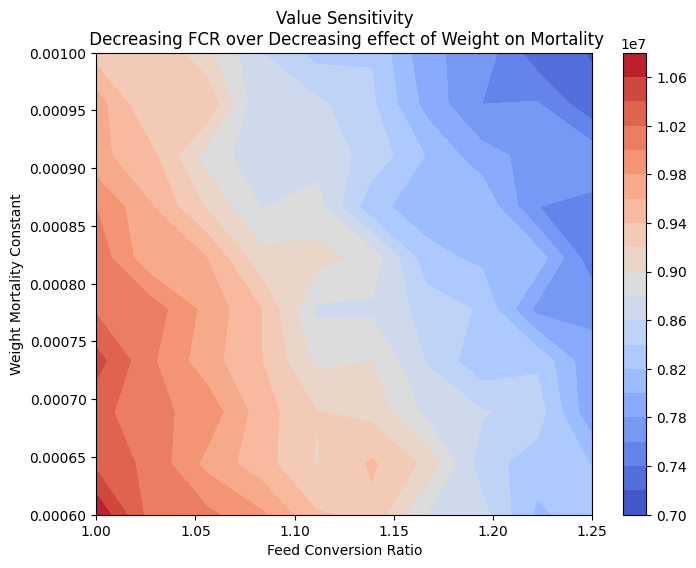

In [236]:
# Generate Heat Map 2: FCR_CCS vs weight_mort_inc_CCS
# [Include the code for Heat Map 2 here]

# Fixed parameters for this heat map
fixed_mu_smoltification_inc_CCS = 0.2  # Fixed mu_smoltification_inc_CCS
fixed_c_CCS = 1.43                       # Fixed growth constant c_CCS

# Initialize an array to store the value differences
value_difference_2 = np.zeros((len(FCR_CCS_values), len(weight_mort_inc_CCS_values)))

for i, FCR_current in enumerate(FCR_CCS_values):
    for j, weight_mort_inc_CCS_current in enumerate(weight_mort_inc_CCS_values):
        # Parameters for CCS
        mu_smoltification_inc_CCS_current = fixed_mu_smoltification_inc_CCS
        c_CCS_current = fixed_c_CCS

        # Simulate CCS (without lice)
        results_CCS = simulate_paths(
            num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0, FCR_current, mu_smoltification_inc, mu_smoltification_inc_CCS, weight_mort_inc, weight_mort_inc_CCS_current, c_CCS, lice_treatment_cost_global, lambda_growth_global, lice_threshold_global
        )
        (simulated_values_CCS, harvesting_costs_CCS, feed_costs_CCS, lice_per_fish_CCS, treatment_costs_CCS,
         mortality_rate_CCS, cumulative_death_CCS, B_t_CCS, D_t_CCS) = results_CCS

        knot_value_CCS, exercise_times_CCS, average_dead_weight_CCS, avg_mortality_rate_CCS = lsmc(
            simulated_values_CCS, harvesting_costs_CCS, r, time_horizon, T, B_t_CCS, D_t_CCS
        )

        # Simulate open cage (with lice)
        results_open = simulate_paths(
            num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0.001, FCR_ONP, mu_smoltification_inc, mu_smoltification_inc_CCS, weight_mort_inc, weight_mort_inc_CCS_current, c_ONP, lice_treatment_cost_global, lambda_growth_global, lice_threshold_global
        )
        (simulated_values_open, harvesting_costs_open, feed_costs_open, lice_per_fish_open, treatment_costs_open,
         mortality_rate_open, cumulative_death_open, B_t_open, D_t_open) = results_open

        knot_value_open, exercise_times_open, average_dead_weight_open, avg_mortality_rate_open = lsmc(
            simulated_values_open, harvesting_costs_open, r, time_horizon, T, B_t_open, D_t_open
        )

        # Calculate value difference
        value_diff = knot_value_CCS - knot_value_open
        value_difference_2[i, j] = value_diff

        print(f"FCR_CCS: {FCR_current:.2f}, weight_mort_inc_CCS: {weight_mort_inc_CCS_current:.4f}, Value Difference: {value_diff:.2f}")

# Generate heat map for Heat Map 2
FCR_CCS_grid, weight_mort_inc_CCS_grid = np.meshgrid(weight_mort_inc_CCS_values, FCR_CCS_values)

plt.figure(figsize=(8, 6))
cp = plt.contourf(weight_mort_inc_CCS_grid, FCR_CCS_grid, value_difference_2, levels=20, cmap='coolwarm')
plt.colorbar(cp)
plt.title('Value Sensitivity\n Decreasing FCR over Decreasing effect of Weight on Mortality')
plt.xlabel('Feed Conversion Ratio')
plt.ylabel('Weight Mortality Constant')
plt.show()


c_CCS: 1.43, weight_mort_inc_CCS: 0.0006, Value Difference: 8423982.42
c_CCS: 1.43, weight_mort_inc_CCS: 0.0006, Value Difference: 7824988.50
c_CCS: 1.43, weight_mort_inc_CCS: 0.0007, Value Difference: 7861640.49
c_CCS: 1.43, weight_mort_inc_CCS: 0.0007, Value Difference: 7813327.42
c_CCS: 1.43, weight_mort_inc_CCS: 0.0008, Value Difference: 7844252.97
c_CCS: 1.43, weight_mort_inc_CCS: 0.0008, Value Difference: 7568596.05
c_CCS: 1.43, weight_mort_inc_CCS: 0.0009, Value Difference: 7676404.38
c_CCS: 1.43, weight_mort_inc_CCS: 0.0009, Value Difference: 7401678.62
c_CCS: 1.43, weight_mort_inc_CCS: 0.0010, Value Difference: 7335731.01
c_CCS: 1.43, weight_mort_inc_CCS: 0.0010, Value Difference: 7281101.89
c_CCS: 1.44, weight_mort_inc_CCS: 0.0006, Value Difference: 8295233.89
c_CCS: 1.44, weight_mort_inc_CCS: 0.0006, Value Difference: 8207821.97
c_CCS: 1.44, weight_mort_inc_CCS: 0.0007, Value Difference: 8041272.71
c_CCS: 1.44, weight_mort_inc_CCS: 0.0007, Value Difference: 8049989.42
c_CCS:

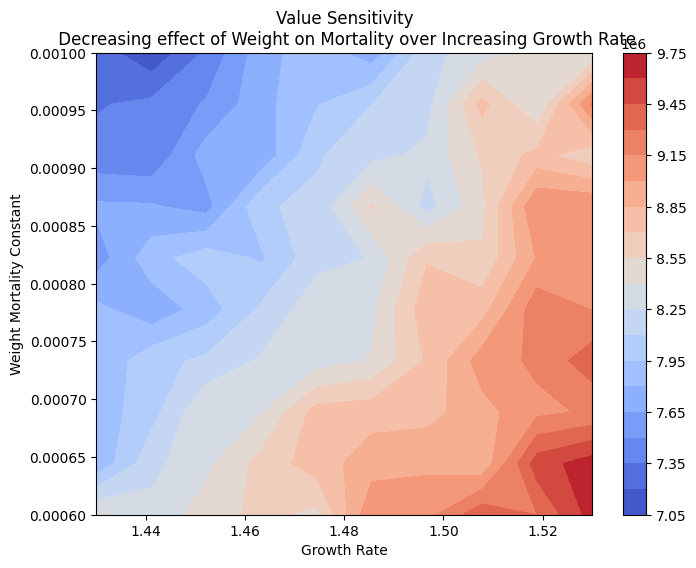

In [237]:
# Generate Heat Map 3: c_CCS vs weight_mort_inc_CCS
# [Include the code for Heat Map 3 here]

# Fixed parameters for this heat map
fixed_FCR_CCS = 1.25                 # Fixed FCR_CCS
fixed_mu_smoltification_inc_CCS = 0.2  # Fixed mu_smoltification_inc_CCS

# Initialize an array to store the value differences
value_difference_3 = np.zeros((len(c_CCS_values), len(weight_mort_inc_CCS_values)))

for i, c_CCS_current in enumerate(c_CCS_values):
    for j, weight_mort_inc_CCS_current in enumerate(weight_mort_inc_CCS_values):
        # Parameters for CCS
        mu_smoltification_inc_CCS_current = fixed_mu_smoltification_inc_CCS
        FCR_CCS_current = fixed_FCR_CCS

        # Simulate CCS (without lice)
        results_CCS = simulate_paths(
            num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0, FCR_CCS, mu_smoltification_inc, mu_smoltification_inc_CCS, weight_mort_inc, weight_mort_inc_CCS_current, c_CCS_current, lice_treatment_cost_global, lambda_growth_global, lice_threshold_global
        )
        (simulated_values_CCS, harvesting_costs_CCS, feed_costs_CCS, lice_per_fish_CCS, treatment_costs_CCS,
         mortality_rate_CCS, cumulative_death_CCS, B_t_CCS, D_t_CCS) = results_CCS

        knot_value_CCS, exercise_times_CCS, average_dead_weight_CCS, avg_mortality_rate_CCS = lsmc(
            simulated_values_CCS, harvesting_costs_CCS, r, time_horizon, T, B_t_CCS, D_t_CCS
        )

        # Simulate open cage (with lice)
        results_open = simulate_paths(
            num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0.001, FCR_ONP, mu_smoltification_inc, mu_smoltification_inc_CCS, weight_mort_inc, weight_mort_inc_CCS_current, c_ONP, lice_treatment_cost_global, lambda_growth_global, lice_threshold_global
        )
        (simulated_values_open, harvesting_costs_open, feed_costs_open, lice_per_fish_open, treatment_costs_open,
         mortality_rate_open, cumulative_death_open, B_t_open, D_t_open) = results_open

        knot_value_open, exercise_times_open, average_dead_weight_open, avg_mortality_rate_open = lsmc(
            simulated_values_open, harvesting_costs_open, r, time_horizon, T, B_t_open, D_t_open
        )

        # Calculate value difference
        value_diff = knot_value_CCS - knot_value_open
        value_difference_3[i, j] = value_diff

        print(f"c_CCS: {c_CCS_current:.2f}, weight_mort_inc_CCS: {weight_mort_inc_CCS_current:.4f}, Value Difference: {value_diff:.2f}")

# Generate heat map for Heat Map 3
c_CCS_grid, weight_mort_inc_CCS_grid = np.meshgrid(weight_mort_inc_CCS_values, c_CCS_values)

plt.figure(figsize=(8, 6))
cp = plt.contourf(weight_mort_inc_CCS_grid, c_CCS_grid, value_difference_3, levels=20, cmap='coolwarm')
plt.colorbar(cp)
plt.title('Value Sensitivity\n Decreasing effect of Weight on Mortality over Increasing Growth Rate')
plt.xlabel('Growth Rate')
plt.ylabel('Weight Mortality Constant')
plt.show()

FCR_CCS: 1.00, lice_treatment_cost: 500000, Value Difference: 7963632.09
FCR_CCS: 1.00, lice_treatment_cost: 555556, Value Difference: 8172869.89
FCR_CCS: 1.00, lice_treatment_cost: 611111, Value Difference: 8270930.54
FCR_CCS: 1.00, lice_treatment_cost: 666667, Value Difference: 8251894.50
FCR_CCS: 1.00, lice_treatment_cost: 722222, Value Difference: 8554203.33
FCR_CCS: 1.00, lice_treatment_cost: 777778, Value Difference: 8689592.85
FCR_CCS: 1.00, lice_treatment_cost: 833333, Value Difference: 9201691.77
FCR_CCS: 1.00, lice_treatment_cost: 888889, Value Difference: 8885620.44
FCR_CCS: 1.00, lice_treatment_cost: 944444, Value Difference: 9218931.27
FCR_CCS: 1.00, lice_treatment_cost: 1000000, Value Difference: 9537475.95
FCR_CCS: 1.03, lice_treatment_cost: 500000, Value Difference: 7840081.68
FCR_CCS: 1.03, lice_treatment_cost: 555556, Value Difference: 7878371.94
FCR_CCS: 1.03, lice_treatment_cost: 611111, Value Difference: 8170995.05
FCR_CCS: 1.03, lice_treatment_cost: 666667, Value 

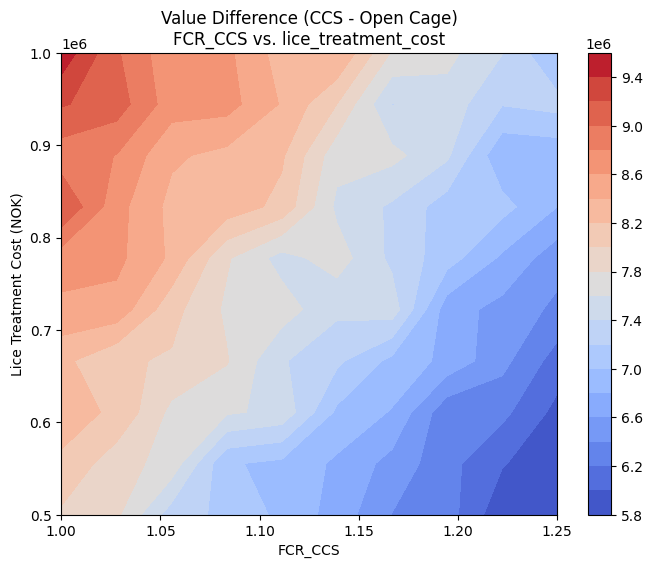

In [238]:
# Generate Heat Map 5: FCR_CCS vs lice_treatment_cost

# Fixed parameters for this heat map
fixed_mu_smoltification_inc_CCS = 0.2  # Fixed mu_smoltification_inc_CCS
fixed_weight_mort_inc_CCS = 0.001      # Fixed weight_mort_inc_CCS
fixed_c_CCS = 1.43                       # Fixed growth constant c_CCS

# Define the parameter ranges
FCR_CCS_values = np.linspace(1.0, 1.25, num=10)
lice_treatment_cost_values = np.linspace(500000, 1000000, num=10)

# Initialize an array to store the value differences
value_difference = np.zeros((len(FCR_CCS_values), len(lice_treatment_cost_values)))

for i, FCR_CCS_current in enumerate(FCR_CCS_values):
    for j, lice_treatment_cost_current in enumerate(lice_treatment_cost_values):
        # Simulate CCS (without lice)
        results_CCS = simulate_paths(
            num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year,
            0, FCR_CCS_current, mu_smoltification_inc, mu_smoltification_inc_CCS, weight_mort_inc, weight_mort_inc_CCS, c_CCS, lice_treatment_cost_current, lambda_growth_global, lice_threshold_global
        )
        (simulated_values_CCS, harvesting_costs_CCS, feed_costs_CCS, lice_per_fish_CCS,
         treatment_costs_CCS, mortality_rate_CCS, cumulative_death_CCS, B_t_CCS, D_t_CCS) = results_CCS

        knot_value_CCS, exercise_times_CCS, average_dead_weight_CCS, avg_mortality_rate_CCS = lsmc(
            simulated_values_CCS, harvesting_costs_CCS, r, time_horizon, T,
            B_t_CCS, D_t_CCS
        )

        # Simulate open cage (with lice)
        results_open = simulate_paths(
            num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year,
            0.001, FCR_ONP, mu_smoltification_inc, mu_smoltification_inc_CCS, weight_mort_inc, weight_mort_inc_CCS, c_ONP, lice_treatment_cost_current, lambda_growth_global, lice_threshold_global
        )
        (simulated_values_open, harvesting_costs_open, feed_costs_open, lice_per_fish_open,
         treatment_costs_open, mortality_rate_open, cumulative_death_open, B_t_open, D_t_open) = results_open

        knot_value_open, exercise_times_open, average_dead_weight_open, avg_mortality_rate_open = lsmc(
            simulated_values_open, harvesting_costs_open, r, time_horizon, T,
            B_t_open, D_t_open
        )

        # Calculate value difference
        value_diff = knot_value_CCS - knot_value_open
        value_difference[i, j] = value_diff

        print(f"FCR_CCS: {FCR_CCS_current:.2f}, lice_treatment_cost: {lice_treatment_cost_current:.0f}, Value Difference: {value_diff:.2f}")

# Generate the heat map
FCR_CCS_grid, lice_treatment_cost_grid = np.meshgrid(lice_treatment_cost_values, FCR_CCS_values)

plt.figure(figsize=(8, 6))
cp = plt.contourf(lice_treatment_cost_grid, FCR_CCS_grid, value_difference, levels=20, cmap='coolwarm')
plt.colorbar(cp)
plt.title('Value Difference (CCS - Open Cage)\nFCR_CCS vs. lice_treatment_cost')
plt.xlabel('FCR_CCS')
plt.ylabel('Lice Treatment Cost (NOK)')
plt.show()

c_CCS: 0.20, weight_mort_inc_CCS: 0.0006, Value Difference: 8136879.56
c_CCS: 0.20, weight_mort_inc_CCS: 0.0006, Value Difference: 8065942.80
c_CCS: 0.20, weight_mort_inc_CCS: 0.0007, Value Difference: 7741872.29
c_CCS: 0.20, weight_mort_inc_CCS: 0.0007, Value Difference: 7581516.75
c_CCS: 0.20, weight_mort_inc_CCS: 0.0008, Value Difference: 7791296.94
c_CCS: 0.20, weight_mort_inc_CCS: 0.0008, Value Difference: 7832386.88
c_CCS: 0.20, weight_mort_inc_CCS: 0.0009, Value Difference: 7387064.56
c_CCS: 0.20, weight_mort_inc_CCS: 0.0009, Value Difference: 7340281.96
c_CCS: 0.20, weight_mort_inc_CCS: 0.0010, Value Difference: 7429366.03
c_CCS: 0.20, weight_mort_inc_CCS: 0.0010, Value Difference: 6980267.39
c_CCS: 0.21, weight_mort_inc_CCS: 0.0006, Value Difference: 7971320.41
c_CCS: 0.21, weight_mort_inc_CCS: 0.0006, Value Difference: 8117621.43
c_CCS: 0.21, weight_mort_inc_CCS: 0.0007, Value Difference: 7858271.32
c_CCS: 0.21, weight_mort_inc_CCS: 0.0007, Value Difference: 7641859.02
c_CCS:

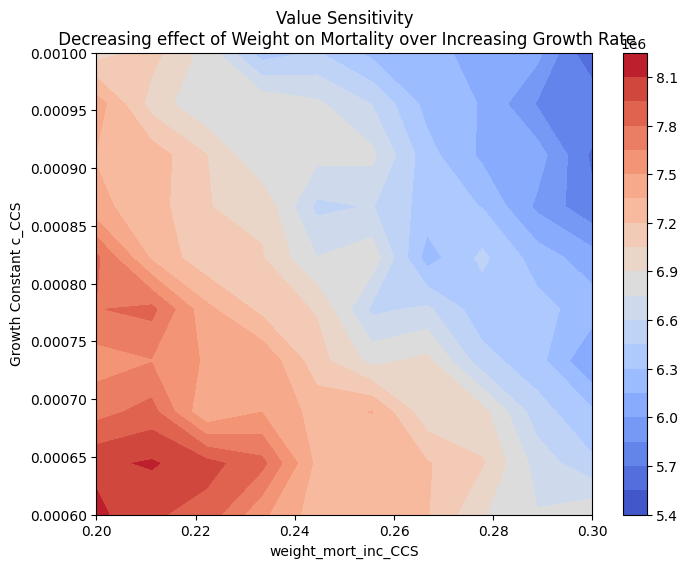

In [239]:
# Generate Heat Map 4: mu_smoltification_inc vs weight_mort_inc_CCS
# [Include the code for Heat Map 3 here]

# Fixed parameters for this heat map
fixed_FCR_CCS = 1.25                 # Fixed FCR_CCS
fixed_c_CCS = 1.43  # Fixed mu_smoltification_inc_CCS

# Initialize an array to store the value differences
value_difference_3 = np.zeros((len(c_CCS_values), len(weight_mort_inc_CCS_values)))

for i, mu_smoltification_inc_CCS_current in enumerate(mu_smoltification_inc_CCS_values):
    for j, weight_mort_inc_CCS_current in enumerate(weight_mort_inc_CCS_values):
        # Parameters for CCS
        c_CCS_current = fixed_c_CCS
        FCR_CCS_current = fixed_FCR_CCS

        # Simulate CCS (without lice)
        results_CCS = simulate_paths(
            num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0, FCR_CCS, mu_smoltification_inc, mu_smoltification_inc_CCS_current, weight_mort_inc, weight_mort_inc_CCS_current, c_CCS, lice_treatment_cost_global, lambda_growth_global, lice_threshold_global
        )
        (simulated_values_CCS, harvesting_costs_CCS, feed_costs_CCS, lice_per_fish_CCS, treatment_costs_CCS,
         mortality_rate_CCS, cumulative_death_CCS, B_t_CCS, D_t_CCS) = results_CCS

        knot_value_CCS, exercise_times_CCS, average_dead_weight_CCS, avg_mortality_rate_CCS = lsmc(
            simulated_values_CCS, harvesting_costs_CCS, r, time_horizon, T, B_t_CCS, D_t_CCS
        )

        # Simulate open cage (with lice)
        results_open = simulate_paths(
            num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0.001, FCR_ONP, mu_smoltification_inc, mu_smoltification_inc_CCS_current, weight_mort_inc, weight_mort_inc_CCS_current, c_ONP, lice_treatment_cost_global, lambda_growth_global, lice_threshold_global
        )
        (simulated_values_open, harvesting_costs_open, feed_costs_open, lice_per_fish_open, treatment_costs_open,
         mortality_rate_open, cumulative_death_open, B_t_open, D_t_open) = results_open

        knot_value_open, exercise_times_open, average_dead_weight_open, avg_mortality_rate_open = lsmc(
            simulated_values_open, harvesting_costs_open, r, time_horizon, T, B_t_open, D_t_open
        )

        # Calculate value difference
        value_diff = knot_value_CCS - knot_value_open
        value_difference_3[i, j] = value_diff

        print(f"c_CCS: {mu_smoltification_inc_CCS_current:.2f}, weight_mort_inc_CCS: {weight_mort_inc_CCS_current:.4f}, Value Difference: {value_diff:.2f}")

# Generate heat map for Heat Map 3
mu_smoltification_inc_CCS_grid, weight_mort_inc_CCS_grid = np.meshgrid(weight_mort_inc_CCS_values, mu_smoltification_inc_CCS_values)

plt.figure(figsize=(8, 6))
cp = plt.contourf(weight_mort_inc_CCS_grid, mu_smoltification_inc_CCS_grid, value_difference_3, levels=20, cmap='coolwarm')
plt.colorbar(cp)
plt.title('Value Sensitivity\n Decreasing effect of Weight on Mortality over Increasing Growth Rate')
plt.xlabel('weight_mort_inc_CCS')
plt.ylabel('Growth Constant c_CCS')
plt.show()